# About: Handwritten digits classification

The purpose of this project is to classify handwritten digits using MNIST dataset which contains $70000$ images of size $28\times 28$ pixels, labeled from 0 to 9. We will use different techniques such as *Multivariate Regression, Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA)* , *Logistic Regression, Neural Networks, Support Vector Machines, Decision Trees and Boosting.*

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn import linear_model, metrics
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # Support vector classifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Loading dataset:**

In [ ]:
mnist = fetch_openml('mnist_784')

In [ ]:
X = mnist.data
y = [int(string_number) for string_number in mnist.target]
target_names = mnist.target_names
mnist.data.shape

(70000, 784)

In [ ]:
#reducing dimension of data:
pca = PCA(n_components=45)
X_pca = pca.fit_transform(X)


X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y,
                                                                     test_size = 0.25,
                                                                     random_state = 42)

In [ ]:
sum(pca.explained_variance_ratio_)

0.8079341174385369

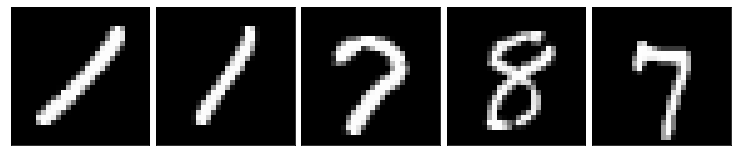

In [ ]:
fig = plt.figure(figsize=(10,10)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot 5 random numbers
j = 1
np.random.seed(0)
for i in np.random.choice(range(70000), 5): 
    ax = fig.add_subplot(1, 5, j, xticks=[], yticks=[]) 
    ax.imshow(np.reshape(X[i,:],(28,28)), cmap=plt.cm.gray, interpolation='nearest') 
    j += 1
plt.show()

**Plotting number frequencies:**

([<matplotlib.axis.XTick at 0x7f6a004bdb50>,
 [Text(0, 0, '5'),
  Text(0, 0, '0'),
  Text(0, 0, '4'),
  Text(0, 0, '1'),
  Text(0, 0, '9'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '6'),
  Text(0, 0, '7'),
  Text(0, 0, '8')])

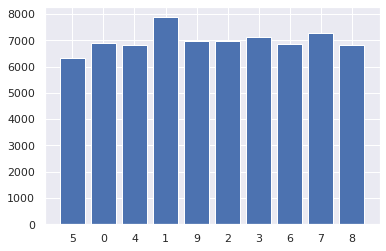

In [ ]:
# counting frequencies
target_numbers_count = Counter(y).items()
target_numbers_count_dict = {}
for key, value in target_numbers_count:
    target_numbers_count_dict[key] = value


    
#plotting frequencies
sns.set(style="darkgrid")
plt.bar(range(10), list(target_numbers_count_dict.values()), align='center')
plt.xticks(range(10), list(target_numbers_count_dict.keys()))

# Multivariate Regression baseline:

The baseline we will use is given by the multivariate linear model:
$$Y=X\hat{B},$$
where $Y_{70000\times 10}$ is an indicator matrix where each row has 0 excepting the value $y_k$ where we put 1.
$X_{70000\times 784}$ is the design matrix and $\hat{B}$ is the matrix whose columns contain the 10 coefficients corresponding to $\hat{\beta_k}$. With this model, we assume a linear model for each response variable $y_k$:
$$\hat{y_k}=X\hat{\beta_k}.$$

And the classification for an observation $x$ follows the next decision rule:
$$\hat{C}(x)=\operatorname{argmax}_{k\in K}\hat{y_k}.$$

**Building Y matrix**

In [ ]:
def indicator(number):
    '''
    Return a vector which contains 1 in the index position 
    given by the number. Otherwise it'll be 0.
    '''
    indicator = [0 for _ in range(10)]
    indicator[number] = 1
    return indicator

Y = map(indicator, y)
Y = np.array(list(Y))
Y[0:10] #showing the first 10 numbers

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

**Splitting in train-test datasets**

In [ ]:
X_train, X_test, y_train, y_test, Y_train, Y_test = train_test_split(X, y, Y,
                                                                     test_size = 0.2,
                                                                     random_state = 42)

**Fitting a linear model to train dataset**

In [ ]:
reg = linear_model.LinearRegression()
linear_regression_model = reg.fit(X_train,Y_train)

**Classifying using the rule decision**

In [ ]:
Y_hat_test = linear_regression_model.predict(X_test)
C_multivariate = map(np.argmax, Y_hat_test)  # classification vector
C_multivariate = list(C_multivariate)
C_multivariate[:5]

[8, 4, 6, 7, 7]

**Comparing predictions vs real values**

In [ ]:
differences = np.array(C_multivariate) - np.array(y_test)
diff_freq = Counter(differences)
correct_predictions_count = diff_freq[0]
correct_predictions_count

11955

**proportion of correct predictions with multivariate regression (Accuracy)**

In [ ]:
accuracy_multivariate = correct_predictions_count/len(y_test)
accuracy_multivariate

0.8539285714285715

**Measuring distinct errors**

In [ ]:
print(metrics.classification_report(y_test, C_multivariate, digits=3))

              precision    recall  f1-score   support

           0      0.901     0.953     0.927      1343
           1      0.809     0.971     0.883      1600
           2      0.903     0.793     0.844      1380
           3      0.825     0.841     0.833      1433
           4      0.819     0.886     0.851      1295
           5      0.876     0.734     0.799      1273
           6      0.893     0.925     0.909      1396
           7      0.869     0.862     0.866      1503
           8      0.842     0.741     0.788      1357
           9      0.827     0.807     0.817      1420

    accuracy                          0.854     14000
   macro avg      0.856     0.851     0.852     14000
weighted avg      0.856     0.854     0.852     14000



# Linear Discriminant Analysis (LDA)

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train, y_train)

In [ ]:
lda_predict = lda_model.predict(X_test)
lda_predict

array([8, 4, 5, ..., 2, 7, 1])

**Measuring distinct errors:**

In [ ]:
print(metrics.classification_report(y_test, lda_predict, digits=3))

              precision    recall  f1-score   support

           0      0.955     0.939     0.947      1343
           1      0.865     0.958     0.909      1600
           2      0.902     0.809     0.853      1380
           3      0.851     0.839     0.845      1433
           4      0.842     0.893     0.867      1295
           5      0.819     0.816     0.817      1273
           6      0.930     0.910     0.920      1396
           7      0.919     0.845     0.880      1503
           8      0.808     0.789     0.798      1357
           9      0.798     0.865     0.830      1420

    accuracy                          0.868     14000
   macro avg      0.869     0.866     0.867     14000
weighted avg      0.869     0.868     0.868     14000



## LDA Model Selection

In [ ]:
parameters = [
  {'n_components' : [2,5,10,20,50]}
]
lda_model_selection = LinearDiscriminantAnalysis()
GS = GridSearchCV(estimator=lda_model_selection, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'n_components': [2, 5, 10, 20, 50]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [ ]:
print('Best score:', GS.best_score_) 
print('Best score:', GS.best_params_) 

Best score: 0.8654428571428572
Best score: {'n_components': 2}


# Quadratic Discriminant Analysis (QDA)

In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(X_train, y_train)

/home/ed4st/anaconda3/envs/DS/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
qda_predict = qda_model.predict(X_test)
qda_predict

array([8, 9, 8, ..., 1, 9, 1])

**Measuring distinct errors:**

In [ ]:
print(metrics.classification_report(y_test, qda_predict, digits=3))

              precision    recall  f1-score   support

           0      0.287     0.972     0.444      1343
           1      0.877     0.948     0.911      1600
           2      0.860     0.213     0.341      1380
           3      0.653     0.270     0.382      1433
           4      0.802     0.066     0.121      1295
           5      0.922     0.075     0.138      1273
           6      0.757     0.946     0.841      1396
           7      0.926     0.283     0.434      1503
           8      0.498     0.458     0.477      1357
           9      0.430     0.950     0.592      1420

    accuracy                          0.529     14000
   macro avg      0.701     0.518     0.468     14000
weighted avg      0.704     0.529     0.480     14000



# Logistic Regression

In [ ]:
log_reg = linear_model.LogisticRegression(solver = 'sag', n_jobs=-1, max_iter=100, multi_class="multinomial")
logistic_model =  log_reg.fit(X_train, y_train)

/home/ed4st/anaconda3/envs/DS/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [ ]:
logistic_predict = logistic_model.predict(X_test)
logistic_predict 

array([8, 4, 5, ..., 2, 7, 1])

**Measuring distinct errors:**

In [ ]:
print(metrics.classification_report(y_test, logistic_predict, digits=3))

              precision    recall  f1-score   support

           0      0.957     0.960     0.958      1343
           1      0.955     0.971     0.963      1600
           2      0.906     0.891     0.899      1380
           3      0.896     0.900     0.898      1433
           4      0.919     0.921     0.920      1295
           5      0.891     0.863     0.876      1273
           6      0.935     0.951     0.943      1396
           7      0.933     0.937     0.935      1503
           8      0.886     0.873     0.879      1357
           9      0.899     0.906     0.902      1420

    accuracy                          0.919     14000
   macro avg      0.918     0.917     0.917     14000
weighted avg      0.918     0.919     0.918     14000



# Applet for prediction

In [ ]:
fitted_models = [linear_regression_model, lda_model, qda_model, lda_model]

In [ ]:
from tkinter import *
from digitsTab import Predict
# ejecutamos el applet
root = Tk()
root.geometry("400x400")
root.resizable(0, 0)
app = Predict(root, fitted_models)
root.mainloop()

# Neural Network

In [ ]:
# The ith element represents the number of neurons in the ith hidden layer.
hls = [10,10]
# regularization parameter
a = .1
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=hls, random_state=0, alpha=a).fit(X_train, y_train)

In [ ]:
# Predicting
NN_predict = mlp.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, NN_predict, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000      1343
           1      0.114     1.000     0.205      1600
           2      0.000     0.000     0.000      1380
           3      0.000     0.000     0.000      1433
           4      0.000     0.000     0.000      1295
           5      0.000     0.000     0.000      1273
           6      0.000     0.000     0.000      1396
           7      0.000     0.000     0.000      1503
           8      0.000     0.000     0.000      1357
           9      0.000     0.000     0.000      1420

    accuracy                          0.114     14000
   macro avg      0.011     0.100     0.021     14000
weighted avg      0.013     0.114     0.023     14000



/home/ed4st/anaconda3/envs/DS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Neural Network Model Selection

**Using Grid Search:**

In [ ]:
parameters = [
  {'hidden_layer_sizes': [[10,],[10,10], [10,2]], 'alpha': [0.01, 0.1, 0.5, 1, 5, 10]}
]
mlp = MLPClassifier(solver='lbfgs', random_state=0)
GS = GridSearchCV(estimator=mlp, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=0, shuffle=True,
                                     solver='lbfgs', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'a

In [ ]:
print('Best score:', GS.best_score_) 
print('Best C:',GS.best_estimator_) 
#print('Best Kernel:',GS.best_estimator_.kernel)
#print('Best Gamma:',GS.best_estimator_.gamma)

Best score: 0.2801571428571429
Best C: MLPClassifier(activation='relu', alpha=10, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[10, 10], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


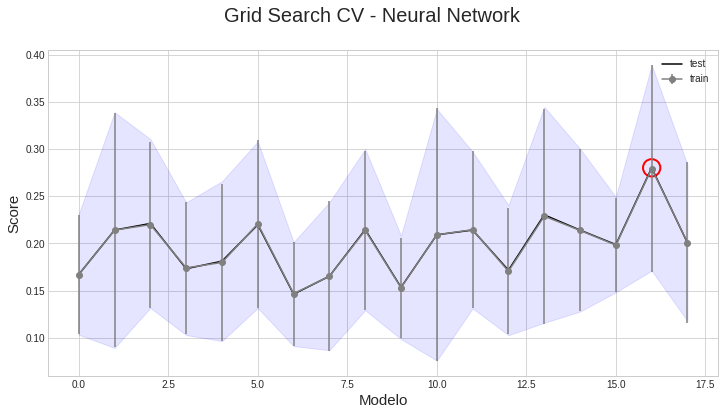

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Neural Network',size=20)
plt.legend(loc="best")
plt.show()

# Reducing dimension of data

# Support Vector Machine

**Grid Search SVM Model Selection**

In [ ]:
parameters = [
    {'kernel': ['linear'], "C":[0.5]},
    {'kernel':['rbf'], 'gamma': [.1, 2], 'C': [0.5]}
]
svm = SVC()
GS = GridSearchCV(estimator=svm, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(X_pca_train,y_train)

In [ ]:
print('Best score:', GS.best_score_) 
print('Best C:',GS.best_estimator_) 

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - SVM',size=20)
plt.legend(loc="best")
plt.show()

# Classification Tree

In [ ]:
parameters = [
    {'max_depth': [2,4,6], "ccp_alpha":[0.01, 0.1, 1, 10]}
]
ctree = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(estimator=ctree, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(X_train_pca,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'ccp_alpha': [0.01, 0.1, 1, 10],
                          'max_depth': [2, 4, 6]}],
             pre_d

In [ ]:
print('Best score:', GS.best_score_) 
print('Best C:',GS.best_estimator_) 

Best score: 0.6266285714285714
Best C: DecisionTreeClassifier(ccp_alpha=0.01, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


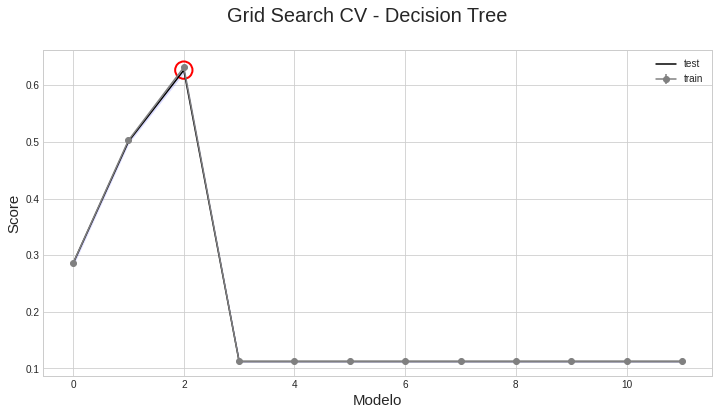

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Decision Tree',size=20)
plt.legend(loc="best")
plt.show()

# Ada Boost

In [ ]:
parameters = [
    {'n_estimators': [10,20,50,100], "learning_rate":[ 0.1, 1, 1.5, 10]}
]
ada_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), algorithm="SAMME")
GS = GridSearchCV(estimator=ada_classifier, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(X_train_pca,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=2,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
      

In [ ]:
print('Best score:', GS.best_score_) 
print('Best C:',GS.best_estimator_) 

Best score: 0.7871809523809523
Best C: AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='de

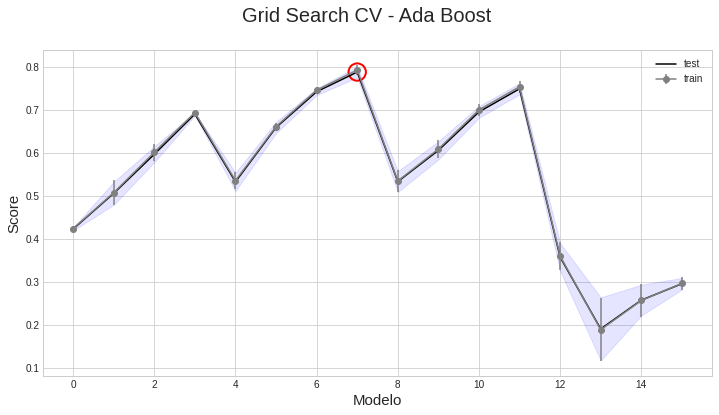

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Ada Boost',size=20)
plt.legend(loc="best")
plt.show()